Dharamvir yadav (MT19CPS012)

In [1]:
import torch
from torchtext import data

SEED = 1234

torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

TEXT = data.Field(tokenize = 'spacy')
LABEL = data.LabelField(dtype = torch.float)

Reading data and preprocessing



In [3]:
import pandas as pd

In [4]:
imdb_data = pd.read_csv("/content/drive/MyDrive/Jovian/review_data.csv") 
print(imdb_data.shape)
imdb_data.head(10)

(50000, 2)


,final_review,sentiment
0,teenager martha moxley maggie grace moves high...,1
1,ok really like kris kristofferson usual easy g...,0
2,spoiler read think watching movie although wou...,0
3,hi people seen wonderful movie im sure thet wo...,1
4,recently bought dvd forgetting much hated movi...,0
5,leave braik put good show finally zorak living...,1
6,nathan detroit frank sinatra manager new york ...,1
7,understand crash course right context must und...,1
8,impressed chavez stance globalisation sometime...,1
9,movie directed renny harlin finnish miracle st...,1


In [152]:
imdb_data.describe()

,sentiment
count,50000.000000
mean,0.500000
std,0.500005
min,0.000000
25%,0.000000
50%,0.500000
75%,1.000000
max,1.000000


In [153]:
imdb_data['sentiment'].value_counts()

1    25000
0    25000
Name: sentiment, dtype: int64

In [5]:
#diveded into three different datasets

train = imdb_data[:40000]
test = imdb_data[40000:46400]
valid = imdb_data[43600:50000]

In [6]:
#convert dataframe to csv file
train.to_csv('train.csv', index=False)
test.to_csv('test.csv', index=False)
valid.to_csv('val.csv',index=False)

In [156]:
import numpy 

In [7]:
# give the format of text and label
tv_datafields = [("text", TEXT), ("label", LABEL)]

In [8]:
train, valid, test = data.TabularDataset.splits(path="",
                                                    train="train.csv", validation="val.csv",
                                                    test="test.csv", format="csv",
                                                    skip_header=True, fields=tv_datafields)

In [9]:
#initial weight define by torchtext is zero but using this we can start it with random values

MAX_VOCAB_SIZE = 25_000

TEXT.build_vocab(train, 
                 max_size = MAX_VOCAB_SIZE, 
                 vectors ="glove.6B.300d", 
                 unk_init = torch.Tensor.normal_)

LABEL.build_vocab(train)

.vector_cache/glove.6B.zip: 862MB [06:27, 2.23MB/s]                           
100%|█████████▉| 399451/400000 [00:37<00:00, 10903.94it/s]

In [66]:
#convert data into the iterable form
batch_size = 64

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train_iterator,valid_iterator,test_iterator = data.BucketIterator.splits((train,valid,test), 
    batch_size = batch_size,sort_key=lambda x: len(x.label), sort_within_batch = True,
    device = device)

# Bidirectional LSTM model with and without attention 


In [13]:
import torch.nn as nn

Bidirectional LSTM without attention model

In [32]:
class BLSTM(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, n_layers, 
                 bidirectional,batch_size, dropout, pad_idx):
        
        super().__init__()
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers
        
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx = pad_idx)
        
        self.rnn = nn.LSTM(embedding_dim, 
                           hidden_dim, 
                           num_layers=n_layers, 
                           bidirectional=bidirectional, 
                           dropout=dropout)
        
        self.fc = nn.Linear(hidden_dim *2, output_dim)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, text, batch_size):
        
        #text = [sent len, batch size]
        
        embedded = self.dropout(self.embedding(text))
        
        #embedded = [sent len, batch size, emb dim]
        h_0 = Variable(torch.zeros(2*self.n_layers,batch_size,self.hidden_dim).to(device))
        c_0 = Variable(torch.zeros(2*self.n_layers,batch_size,self.hidden_dim).to(device))
        output, (hidden,final_cell_state) = self.rnn(embedded,(h_0,c_0))
        
        
        hidden = self.dropout(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim = 1))
                
        #hidden = [batch size, hid dim * num directions]
            
        return self.fc(hidden)

In [33]:
INPUT_DIM = len(TEXT.vocab)
EMBEDDING_DIM = 100
HIDDEN_DIM = 256
OUTPUT_DIM = 1
N_LAYERS = 2
BIDIRECTIONAL = True
DROPOUT = 0.5
PAD_IDX = TEXT.vocab.stoi[TEXT.pad_token]
batch_size = 64

model = BLSTM(INPUT_DIM, 
            EMBEDDING_DIM, 
            HIDDEN_DIM, 
            OUTPUT_DIM, 
            N_LAYERS, 
            BIDIRECTIONAL, 
            batch_size,
            DROPOUT, 
            PAD_IDX)

bidirectional LSTM with attention

In [45]:
class ABLSTM1(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, n_layers, 
                 bidirectional,batch_size, dropout, pad_idx):
        
        super().__init__()
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers
        
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx = pad_idx)
        
        self.rnn = nn.LSTM(embedding_dim, 
                           hidden_dim, 
                           num_layers=n_layers, 
                           bidirectional=bidirectional, 
                           dropout=dropout)
        
        self.fc = nn.Linear(hidden_dim *2 , output_dim)
        
        self.dropout = nn.Dropout(dropout)
    
    
    
     
        
    def forward(self, text, batch_size):
        
        #text = [sent len, batch size]
        
        embedded = self.dropout(self.embedding(text))
        #embedded = embedded.permute(1,0,2)
        
        #embedded = [sent len, batch size, emb dim]
        h_0 = Variable(torch.zeros(2*self.n_layers,batch_size,self.hidden_dim).to(device))
        c_0 = Variable(torch.zeros(2*self.n_layers,batch_size,self.hidden_dim).to(device))
        output, (hidden,final_cell_state) = self.rnn(embedded,(h_0,c_0))
        
        
        output = output.permute(1,0,2)
        #print(output.shape)
        hidden = self.dropout(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim = 1))
        hidden = hidden.squeeze(0)
        #print(hidden.shape)
        #print(lstm_output.shape)

        # attention part
        attn_weights = torch.bmm(output, hidden.unsqueeze(2)).squeeze(2)
        soft_attn_weights = F.softmax(attn_weights, 1)
        new_hidden_state = torch.bmm(output.transpose(1, 2), soft_attn_weights.unsqueeze(2)).squeeze(2)
        #print(hidden.shape)
        #attn_output = self.attention_net(output,hidden)        
        #hidden = [batch size, hid dim * num directions]
            
        return self.fc(new_hidden_state)

In [144]:
import math

In [46]:
INPUT_DIM = len(TEXT.vocab)
EMBEDDING_DIM = 100
HIDDEN_DIM = 256
OUTPUT_DIM = 1
N_LAYERS = 2
BIDIRECTIONAL = True
DROPOUT = 0.5
PAD_IDX = TEXT.vocab.stoi[TEXT.pad_token]
batch_size = 64

model1 = ABLSTM1(INPUT_DIM, 
            EMBEDDING_DIM, 
            HIDDEN_DIM, 
            OUTPUT_DIM, 
            N_LAYERS, 
            BIDIRECTIONAL, 
            batch_size,
            DROPOUT, 
            PAD_IDX)



In [16]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 4,810,857 trainable parameters


In [17]:
pretrained_embeddings = TEXT.vocab.vectors

print(pretrained_embeddings.shape)

torch.Size([25002, 300])


In [19]:
UNK_IDX = TEXT.vocab.stoi[TEXT.unk_token]

model.embedding.weight.data[UNK_IDX] = torch.zeros(EMBEDDING_DIM)
model.embedding.weight.data[PAD_IDX] = torch.zeros(EMBEDDING_DIM)

print(model.embedding.weight.data)

tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 1.0185,  1.5625,  0.5127,  ..., -0.0139,  0.9483, -0.5734],
        ...,
        [ 1.7303,  0.6817,  0.7259,  ..., -0.2082, -1.1360,  0.8817],
        [-0.3057, -2.0466,  0.6402,  ..., -0.6624,  1.1352,  0.8474],
        [-0.8388, -1.2352, -2.5955,  ...,  0.1487, -0.1174,  1.0730]])


optimizer and loss function

In [34]:
import torch.optim as optim

optimizer = optim.Adam(model.parameters(),lr=0.0001)

In [35]:
criterion = nn.BCEWithLogitsLoss()

model = model.to(device)
criterion = criterion.to(device)

optimizer and loss function with attention model

In [47]:
import torch.optim as optim

optimizer1 = optim.Adam(model1.parameters(), lr=0.0001)

In [49]:
criterion1 = nn.BCEWithLogitsLoss()

model1 = model1.to(device)
criterion1 = criterion.to(device)

In [50]:
def binary_accuracy(preds, y):
    """
    Returns accuracy per batch, i.e. if you get 8/10 right, this returns 0.8, NOT 8
    """

    #round predictions to the closest integer
    rounded_preds = torch.round(torch.sigmoid(preds))
    correct = (rounded_preds == y).float() #convert into float for division 
    acc = correct.sum() / len(correct)
    return acc

training and evalute part without attention

In [51]:
def train(model, iterator, optimizer, criterion):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.train()
    
    for batch in iterator:
        
        optimizer.zero_grad()
        
        #text, text_lengths = batch.text
        batch_size =64
        
        predictions = model(batch.text.to(device),batch_size).squeeze(1)
        
        loss = criterion(predictions, batch.label.to(device))
        
        acc = binary_accuracy(predictions,batch.label.to(device))
        
        loss.backward()
        
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [52]:



def evaluate(model, iterator, criterion):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.eval()
    
    with torch.no_grad():
    
        for batch in iterator:

            #text, text_lengths = batch.text
            
            batch_size = 64
            predictions = model(batch.text.to(device),batch_size).squeeze(1)
            
            loss = criterion(predictions, batch.label.to(device))
            
            acc = binary_accuracy(predictions, batch.label.to(device))

            epoch_loss += loss.item()
            epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

Train and evalute model of the with attention model

In [53]:
def train1(model, iterator, optimizer, criterion):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.train()
    
    for batch in iterator:
        
        optimizer.zero_grad()
        
        #text, text_lengths = batch.text
        batch_size =64
        
        predictions = model(batch.text.to(device),batch_size).squeeze(1)
        
        loss = criterion(predictions, batch.label.to(device))
        
        acc = binary_accuracy(predictions,batch.label.to(device))
        
        loss.backward()
        
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [54]:
def evaluate1(model, iterator, criterion):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.eval()
    
    with torch.no_grad():
    
        for batch in iterator:

            #text, text_lengths = batch.text
            
            batch_size = 64
            predictions = model(batch.text.to(device),batch_size).squeeze(1)
            
            loss = criterion(predictions, batch.label.to(device))
            
            acc = binary_accuracy(predictions, batch.label.to(device))

            epoch_loss += loss.item()
            epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [55]:
import time

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [56]:
from torch.autograd import Variable

In [57]:
N_EPOCHS = 10

In [58]:
import torch.nn.functional as F

train for Biderectional LSTM

In [42]:
train_losses = []
valid_losses = []
best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):

    start_time = time.time()
    
    train_loss, train_acc = train(model, train_iterator, optimizer, criterion)
    valid_loss, valid_acc = evaluate(model, valid_iterator, criterion)
    
    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'BLSTM-model.pt')
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

Epoch: 01 | Epoch Time: 2m 21s
	Train Loss: 0.670 | Train Acc: 57.52%
	 Val. Loss: 0.642 |  Val. Acc: 61.58%
Epoch: 02 | Epoch Time: 2m 22s
	Train Loss: 0.604 | Train Acc: 67.26%
	 Val. Loss: 0.565 |  Val. Acc: 70.62%
Epoch: 03 | Epoch Time: 2m 22s
	Train Loss: 0.542 | Train Acc: 73.08%
	 Val. Loss: 0.483 |  Val. Acc: 77.84%
Epoch: 04 | Epoch Time: 2m 22s
	Train Loss: 0.498 | Train Acc: 76.30%
	 Val. Loss: 0.485 |  Val. Acc: 77.91%
Epoch: 05 | Epoch Time: 2m 21s
	Train Loss: 0.545 | Train Acc: 73.06%
	 Val. Loss: 0.466 |  Val. Acc: 78.44%
Epoch: 06 | Epoch Time: 2m 21s
	Train Loss: 0.464 | Train Acc: 78.86%
	 Val. Loss: 0.397 |  Val. Acc: 82.61%
Epoch: 07 | Epoch Time: 2m 21s
	Train Loss: 0.431 | Train Acc: 80.73%
	 Val. Loss: 0.388 |  Val. Acc: 83.14%
Epoch: 08 | Epoch Time: 2m 21s
	Train Loss: 0.423 | Train Acc: 81.49%
	 Val. Loss: 0.383 |  Val. Acc: 83.34%
Epoch: 09 | Epoch Time: 2m 22s
	Train Loss: 0.478 | Train Acc: 77.64%
	 Val. Loss: 0.450 |  Val. Acc: 78.23%
Epoch: 10 | Epoch T

In [43]:
import matplotlib.pyplot as plt


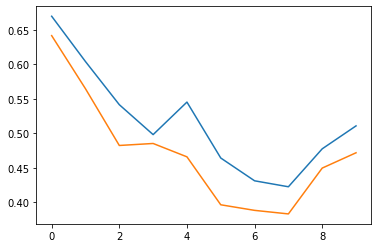

In [44]:
plt.plot(train_losses)
plt.plot(valid_losses)

train for Biderectional with attention

In [59]:
train_loss_a = []
valid_loss_a = []
best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):

    start_time = time.time()
    
    train_loss, train_acc = train(model1, train_iterator, optimizer1, criterion1)
    valid_loss, valid_acc = evaluate(model1, valid_iterator, criterion1)
    
    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'ABLSTM-model.pt')
    train_loss_a.append(train_loss)
    valid_loss_a.append(valid_loss)
    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

Epoch: 01 | Epoch Time: 2m 26s
	Train Loss: 0.653 | Train Acc: 60.67%
	 Val. Loss: 0.575 |  Val. Acc: 69.84%
Epoch: 02 | Epoch Time: 2m 27s
	Train Loss: 0.599 | Train Acc: 67.62%
	 Val. Loss: 0.565 |  Val. Acc: 68.61%
Epoch: 03 | Epoch Time: 2m 27s
	Train Loss: 0.600 | Train Acc: 65.85%
	 Val. Loss: 0.546 |  Val. Acc: 71.94%
Epoch: 04 | Epoch Time: 2m 27s
	Train Loss: 0.611 | Train Acc: 67.01%
	 Val. Loss: 0.584 |  Val. Acc: 72.25%
Epoch: 05 | Epoch Time: 2m 27s
	Train Loss: 0.566 | Train Acc: 71.41%
	 Val. Loss: 0.509 |  Val. Acc: 76.31%
Epoch: 06 | Epoch Time: 2m 27s
	Train Loss: 0.529 | Train Acc: 74.07%
	 Val. Loss: 0.471 |  Val. Acc: 77.98%
Epoch: 07 | Epoch Time: 2m 27s
	Train Loss: 0.502 | Train Acc: 75.93%
	 Val. Loss: 0.443 |  Val. Acc: 79.83%
Epoch: 08 | Epoch Time: 2m 28s
	Train Loss: 0.479 | Train Acc: 77.36%
	 Val. Loss: 0.420 |  Val. Acc: 80.50%
Epoch: 09 | Epoch Time: 2m 27s
	Train Loss: 0.455 | Train Acc: 78.68%
	 Val. Loss: 0.402 |  Val. Acc: 82.31%
Epoch: 10 | Epoch T

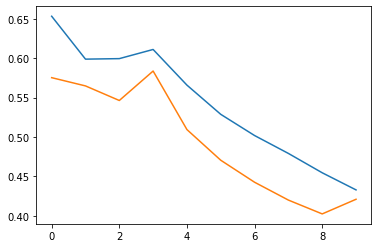

In [61]:
plt.plot(train_loss_a)
plt.plot(valid_loss_a)

Testing for bidirectional lstm 

In [62]:
model.load_state_dict(torch.load('BLSTM-model.pt'))

test_loss, test_acc = evaluate(model, test_iterator, criterion)

print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

Test Loss: 0.388 | Test Acc: 82.94%


testing for bidirectional Lstm with attention

In [60]:
model.load_state_dict(torch.load('ABLSTM-model.pt'))

test_loss, test_acc = evaluate(model1, test_iterator, criterion)

print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

Test Loss: 0.431 | Test Acc: 80.69%


In [64]:
import numpy as np

In [78]:
batch_size = 64
predicted_labels = []
prediction_probabilities = []
actual_labels = []
predicted = []
num_correct = 0
total_images = 0
confusion_mat = np.zeros([200,200],int)              #inintializing the confusion matrix
with torch.no_grad():
    for batch in test_iterator:
      #inputs = batch.text.to(device)
      labels = batch.label.to(device)
      outputs = model(batch.text.to(device),batch_size).squeeze(1)
      prediction_probabilities += list(np.array(outputs.detach().cpu()))
            
      loss = criterion(outputs, batch.label.to(device))
      #outputs  = model(inputs,batch_size)
      #loss = criterion(outputs,labels)
      pred = torch.round(outputs.squeeze())
      predicted_labels += list(np.array(pred.detach().cpu(),dtype=int))
      actual_labels += list(np.array(labels.detach().cpu(),dtype=int))
    
    # compare predictions to true label
      correct_tensor = pred.eq(labels.float().view_as(pred))
      correct = np.squeeze(correct_tensor.cpu().numpy())
      num_correct += np.sum(correct)
      #_,predicted = torch.max(outputs,1)

      total_images += labels.size(0)
      #total_correct += (pred == labels).sum().item()
      #for i, l in enumerate(labels):
       # confusion_mat[l.item(), pred[i].item()] += 1          # Row = actual class , COl = predicted class                      

model_accuracy = num_correct / total_images * 100
print('Model accuracy on {0} test images: {1:.2f}%'.format(total_images, model_accuracy))

Model accuracy on 6400 test images: 18.41%


In [100]:
epoch_loss = 0
epoch_acc = 0
model.eval()
prediction_probabilities = []
actual_labels = []
predicted_labels = []

    
with torch.no_grad():

    
  for batch in test_iterator:

            #text, text_lengths = batch.text
            
            batch_size = 64
            predictions = model(batch.text.to(device),batch_size).squeeze(1)
            prediction_probabilities += list(np.array(predictions.detach().cpu()))
            
            loss = criterion(predictions, batch.label.to(device))
            pred = torch.round(torch.sigmoid(predictions))
            #pred = torch.round(outputs.squeeze())
            predicted_labels += list(np.array(pred.detach().cpu(),dtype=int))
            actual_labels += list(np.array(batch.label.detach().cpu(),dtype=int))
            
            acc = binary_accuracy(predictions, batch.label.to(device))

            epoch_loss += loss.item()
            epoch_acc += acc.item()

#return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [101]:
def confusion_matrix(actual, predicted):
  TP, TN, FP, FN = 0, 0, 0, 0
  for a,b in zip(actual, predicted):
    if a == b == 1:
      TP += 1

    elif a == b == 0:
      TN += 1
    
    elif a == 1 and b == 0:
      FN += 1
    
    else:
      TN += 1
  
  return TP, TN, FP, FN

In [102]:
TP, TN, FP, FN = confusion_matrix(actual_labels, predicted_labels)
print([[TP,FP],[FN,TN]])

[[2628, 0], [601, 3171]]


In [103]:
epoch_loss = 0
epoch_acc = 0
model.eval()
prediction_probabilities1 = []
actual_labels1 = []
predicted_labels1 = []

    
with torch.no_grad():

    
  for batch in test_iterator:

            #text, text_lengths = batch.text
            
            batch_size = 64
            predictions = model1(batch.text.to(device),batch_size).squeeze(1)
            prediction_probabilities1 += list(np.array(predictions.detach().cpu()))
            
            loss = criterion(predictions, batch.label.to(device))
            pred = torch.round(torch.sigmoid(predictions))
            #pred = torch.round(outputs.squeeze())
            predicted_labels1 += list(np.array(pred.detach().cpu(),dtype=int))
            actual_labels1 += list(np.array(batch.label.detach().cpu(),dtype=int))
            
            acc = binary_accuracy(predictions, batch.label.to(device))

            epoch_loss += loss.item()
            epoch_acc += acc.item()

#return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [104]:
TP, TN, FP, FN = confusion_matrix(actual_labels1, predicted_labels1)
print([[TP,FP],[FN,TN]])

[[2245, 0], [984, 3171]]


In [105]:
def get_ROC_curve(apredicted_labels, probabilities):

    dat = np.hstack(( np.array(apredicted_labels).reshape(-1,1), np.array(probabilities).reshape(-1,1) ))
    dataset = pd.DataFrame(dat, columns=["y","proba"])
    
    # lists to store TPR and FRP values
    TPR_values = []
    FPR_values = []
    nrows = len(dataset)  
    
    # Sort dataframe in descending order by probability values
    dataset.sort_values("proba",ascending = False , inplace = True)
    
    # A list that stores the actual class labels
    act_list = dataset["y"].tolist()
    
    # A list that stores the probability scores
    prob_list = dataset["proba"].tolist()
    
    # Calculate the number of positive values
    P = dataset["y"].tolist().count(1)
    
    # Calculate the number of negative values
    N = dataset["y"].tolist().count(0)
    
    for i in range(0,nrows):
        
        # Select the threshold
        thresh = prob_list[i]
        
        # Initialize TP and FP to zero
        TP = FP = 0        
        
        # Calculate The number of true positives and number of false positive for each threshold
        for j in range(0,nrows):
            class_label = 1 if prob_list[j]>=thresh else 0
            actual_label = act_list[j]
            
            if class_label == 1:
                if actual_label ==1:
                    TP += 1
                else:
                    FP += 1
        # Append them to the array
        TPR_values.append(TP/P)
        FPR_values.append(FP/N)
    
    # Plot the ROC Curve
    print("The ROC Curve is:")
    plt.plot(FPR_values, TPR_values,label="ROC Curve")
    plt.grid()
    plt.legend()
    plt.show()

In [88]:
def get_PRC_Curve(y_test_probs,actual):
  probability_thresholds = np.linspace(0, 1, num=100)

  precision_scores = []
  recall_scores = []

  for p in probability_thresholds:
    y_test_preds = []
    
    for prob in y_test_probs:
        if prob > p:
          y_test_preds.append(1)
        else:
          y_test_preds.append(0)
            
    precision, recall = calc_precision_recall(actual, y_test_preds)
        
    precision_scores.append(precision)
    recall_scores.append(recall)

  plt.plot(precision_scores, label='PRECISION', color='red')
  plt.plot(recall_scores, label='RECALL', color='green')
  plt.plot(recall_scores, precision_scores, color='green', label = 'PR Curve')
  plt.legend()
  plt.grid()
  plt.plot()

The ROC Curve is:


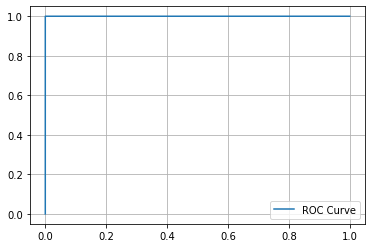

In [107]:
get_ROC_curve(predicted_labels, prediction_probabilities)

The ROC Curve is:


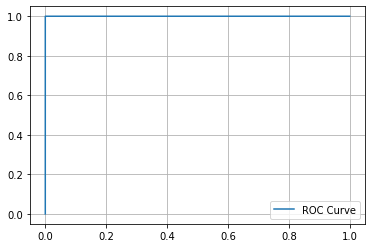

In [106]:
get_ROC_curve(predicted_labels1, prediction_probabilities1)